# Ozone forcing


Skeie et al. 2021:

- time series of all depleters, warming included

Individual contributions to present day ozone forcing (estimated from figure 7, Thornhill et al 2021) with no climate contribution:

- N2O +0.04
- VOC +0.11
- NOx -0.14
- CH4 +0.17  (O'Connor et al. says +0.13 or +0.20 depending on method; we use +0.13)
- HC  -0.33
- climate -0.079 W/m2/K
- sum +0.13  (+0.09 with pre-calibrated methane from O'Connor which does not include climate feedback)

This falls a little short, possibly the use of the ozone radiative kernel means that estimates are not perfect in either Skeie or Thornhill x 2, or that there is some additional non-linearity that kicks into the estimates.

**Possible effect of ACI from ozone: drove a stronger negative forcing than expected**

**look at histSST-piO3 and fit the time series to emissions of NOx, VOC and CO**

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
st_df = pd.read_csv('../data/skeie2020/skeie_ozone_strat.csv', index_col="Model")
tr_df = pd.read_csv('../data/skeie2020/skeie_ozone_trop.csv', index_col="Model")

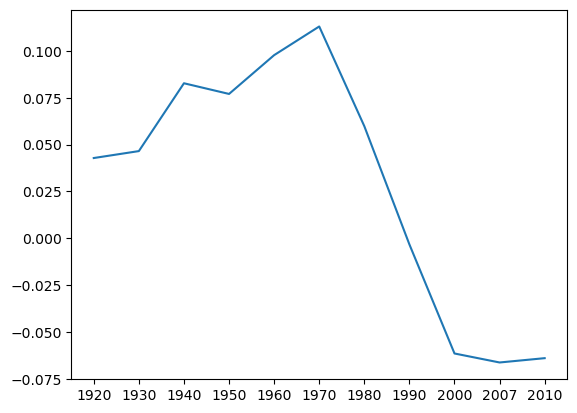

In [3]:
# Skeie uses 10 year averages: 1920 is 1916-1925 up to 2000. 2007 is 2003-2012. 2010 is 2005-2014.
o3_ukesm = st_df.loc['UKESM1-0-LL'] + tr_df.loc['UKESM1-0-LL']
pl.plot(o3_ukesm)

In [4]:
temp_ukesm = np.ones((165, 19)) * np.nan
for run in range(19):
    try:
        temp_ukesm[:, run] = pd.read_csv('../data/fredriksen2022/historical/UKESM1-0-LL_historical_r%di1p1f2_anomalies.txt' %(run+1), index_col=0)['tas'].values
    except FileNotFoundError:
        pass

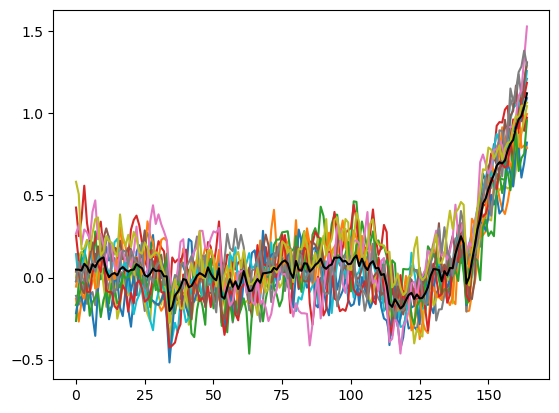

In [5]:
pl.plot(temp_ukesm);
temp_ukesm_mean = np.nanmean(temp_ukesm, axis=1)
pl.plot(temp_ukesm_mean, color='k')

In [6]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [7]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [8]:
f = FAIR(temperature_prescribed=True)

In [9]:
scenarios = ['ssp245']
configs = ['UKESM1-0-LL']
species, properties = read_properties()
species.remove('CO2 FFI')      # c-driven run
species.remove('CO2 AFOLU')    # c-driven run
species.remove('Halon-1202')   # not in CMIP6 list of species
species.remove('Contrails')    # not modelled in UKESM, I think
species.remove('NOx aviation') # which renders this redundant
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
del properties['CO2 FFI']
del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']
for specie in species:
    if properties[specie]['greenhouse_gas']:
        properties[specie]['input_mode'] = 'concentration'
properties['Land use']['input_mode'] = 'forcing'
properties

{'CO2': {'type': 'co2',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CH4': {'type': 'ch4',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'N2O': {'type': 'n2o',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'Sulfur': {'type': 'sulfur',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': True,
  'aerosol_chemistry_from_concentration': False},
 'BC': {'type': 'black carbon',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': True,
  'aerosol_chemistry_from_concentration': False},
 'OC': {'type': 'organic carbon',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemi

In [10]:
f.define_time(1850, 2015, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)

In [11]:
f.allocate()

In [12]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [13]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [14]:
f.fill_species_configs()

In [15]:
f.fill_from_rcmip()

In [16]:
# override RCMIP natural forcing
fill(f.forcing, natural_forcing_df.loc[1850:2015, 'solar'][:, None, None], specie='Solar')
fill(f.forcing, natural_forcing_df.loc[1850:2015, 'volcanic'][:, None, None], specie='Volcanic')

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_89781/1549949875.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'solar'][:, None, None], specie='Solar')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_89781/1549949875.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'volcanic'][:, None, None], specie='Volcanic')


In [17]:
f.emissions[:,0,0,3:10]

<xarray.DataArray (timepoints: 165, specie: 7)>
array([[  4.54446378,   2.57112448,  18.22682479, ...,  13.45657685,
         66.78304875, 411.46287432],
       [  4.50659972,   2.52669259,  17.72630049, ...,  13.17243992,
         64.95004659, 402.24481525],
       [  4.54817338,   2.50763416,  17.47926155, ...,  13.00181932,
         63.95789986, 397.49851999],
       ...,
       [115.66957641,   9.70528517,  35.82690196, ..., 158.23998797,
        229.10693624, 949.60221835],
       [114.64817742,   9.56055374,  33.24556583, ..., 156.03755649,
        219.38117925, 901.23875664],
       [114.0086622 ,   9.74437966,  36.14582139, ..., 155.64022547,
        233.52551801, 964.04761815]])
Coordinates:
  * timepoints  (timepoints) float64 1.85e+03 1.852e+03 ... 2.014e+03 2.014e+03
    scenario    <U6 'ssp245'
    config      <U11 'UKESM1-0-LL'
  * specie      (specie) <U43 'Sulfur' 'BC' 'OC' 'NH3' 'NOx' 'VOC' 'CO'

In [18]:
f.emissions.loc[dict(specie='Sulfur', timepoints=1850.5)]

<xarray.DataArray (scenario: 1, config: 1)>
array([[4.54446378]])
Coordinates:
    timepoints  float64 1.85e+03
  * scenario    (scenario) <U6 'ssp245'
  * config      (config) <U11 'UKESM1-0-LL'
    specie      <U43 'Sulfur'

In [19]:
landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
f.forcing.loc[dict(specie='Land use')] = landuse_erf.values[:, None]

In [20]:
species

['CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'BC',
 'OC',
 'NH3',
 'NOx',
 'VOC',
 'CO',
 'CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee',
 'Solar',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions',
 'Ozone',
 'Stratospheric water vapour',
 'Land use',
 'Equivalent effective stratospheric chlorine']

In [21]:
# 1850 baselines
for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 0

## rebase volcanic to zero mean
#f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()

In [22]:
# fill temperature
f.temperature[:-1, ...] = temp_ukesm_mean[:, None, None, None]
f.temperature[-1, ...] = f.temperature[-2, ...]

# pre-calibrated for aerosol and CH4 runs: do not adjust
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00447635
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.05297455
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.00781294
f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -0.63667782
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 0.03110931
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 0.00221948
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 0.00864984
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie="CH4")] = -5.09377882e-05
f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -3.54174562e-04

# # co-calibrated with N2O runs:
# f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.0632

In [23]:
ch4 = f.concentration.loc[dict(specie='CH4')].squeeze().values
n2o = f.concentration.loc[dict(specie='N2O')].squeeze().values
eesc = f.concentration.loc[dict(specie='Equivalent effective stratospheric chlorine')].squeeze().values

voc = f.emissions.loc[dict(specie='VOC')].squeeze().values
co = f.emissions.loc[dict(specie='CO')].squeeze().values
nox = f.emissions.loc[dict(specie='NOx')].squeeze().values
print(eesc[-2])

nan


In [24]:
# values from Thornhill
n2o_eff = 0.04 / (n2o[164]-n2o[0])
voc_eff = 0.11 / (voc[164]-voc[0])
nox_eff = 0.14 / (nox[164]-nox[0])
eesc_eff = -0.33 / (1.13324964e+03)  # precalc
n2o_eff, voc_eff, nox_eff, eesc_eff

(0.0007481397748679878,
 0.0006596999582126578,
 0.000984642055228785,
 -0.00029119797470220245)

In [25]:
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = eesc_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = n2o_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = voc_eff
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = nox_eff
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.079  # Thornhill et al 2021 feedbacks

In [26]:
f.run()

Running 1 projections in parallel:   0%|          | 0/165 [00:00<?, ?timesteps/s]

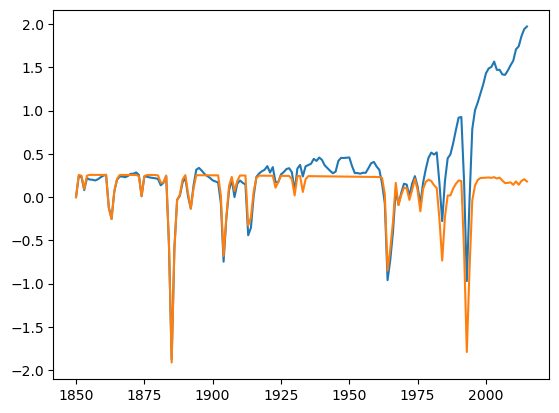

In [27]:
pl.plot(f.timebounds, f.forcing_sum[:,0,0])
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')])

In [28]:
# print('N2O               %+7.5f' % f.forcing.values[-2:-1,0,0,1].mean())
print('Ozone             %+7.5f' % f.forcing.values[-2:-1,0,0,54].mean())
# print('ARI               %+7.5f' % f.forcing.values[-2:-1,0,0,10].mean())
# print('ACI               %+7.5f' % f.forcing.values[-2:-1,0,0,11].mean())
# print('Sum of components %+7.5f' % (f.forcing.values[-2:-1,0,0,1]+f.forcing.values[-2:-1,0,0,9]+f.forcing.values[-2:-1,0,0,10]+f.forcing.values[-2:-1,0,0,11]))
print('Scenario sum      %+7.5f' % f.forcing_sum.values[-2:-1,0,0].mean())

Ozone             +0.07411
Scenario sum      +1.94235


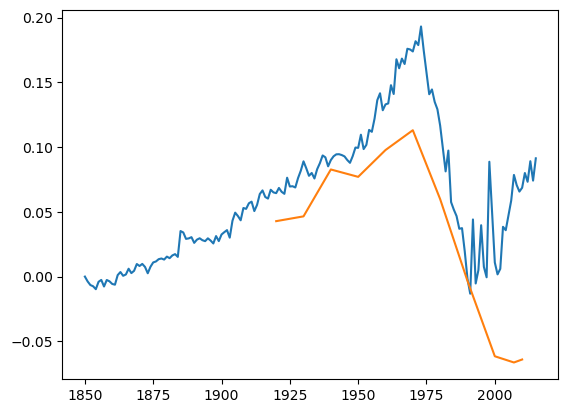

In [29]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Ozone', scenario='ssp245', config='UKESM1-0-LL')])
pl.plot(o3_ukesm.index.map(float), o3_ukesm)